In [1]:
import pandas as pd
import numpy as np

# 1727, 191
train = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/d-optimal-of-spmm/train-test-csv/1727-nonsquare-train-from-1918-nonsquare-spmm-over-3s.csv')
test = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/d-optimal-of-spmm/train-test-csv/191-nonsquare-test-from-1918-nonsquare-spmm-over-3s.csv')

In [4]:
# feature 1개 추가 -> MAPE 9

# Train + Valid
X_train = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz']] 
y_train = train['bz_smsm']

# Test
X_test = test[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz']] 
y_test = test['bz_smsm']

In [6]:
from sklearn.metrics import r2_score, mean_squared_error

# Metric
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def custom_scoring(real, pred):
    rmse = np.sqrt(mean_squared_error(real, pred))
    r2 = r2_score(real, pred)
    mape = mean_absolute_percentage_error(real, pred)
    return mape

In [7]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

# 탐색 대상 함수 (XGBRegressor)
def XGB(
max_depth,
learning_rate, 
n_estimators, 
#min_child_weight, 
subsample,
_lambda,
#gamma ,
colsample_bytree, 
#_alpha,
silent=True, 
n_jobs=-1):
    
    # 모델 정의
    model = xgb.XGBRegressor( 
objective = 'reg:squarederror',
max_depth=int(max_depth),
learning_rate=learning_rate,
n_estimators=int(n_estimators),
#min_child_weight=min_child_weight,
subsample=subsample,
reg_lambda=_lambda,        
#gamma=gamma,
colsample_bytree=colsample_bytree, 
#reg_alpha=_alpha
n_jobs=n_jobs        
                              )
    
    # bayesian optimization을 통해 파라미터를 받아
    # Train을 Train + Validation으로 나눠 cross-validation 성능 확인
    kfold = KFold(n_splits=9, shuffle = True, random_state=0)

    # cross-validation 평균 성능 성능 확인
    score = cross_val_score(model,
                            X_train, 
                            y_train, 
                            cv=kfold,
                            scoring=make_scorer(custom_scoring,greater_is_better=False),
                            n_jobs=-1
                           ).mean()
    
    return score

In [8]:
from bayes_opt import BayesianOptimization

# 하이퍼파라미터 정의
pbounds = {
'max_depth': (15, 23), 
'learning_rate': (0.01, 0.3),
'n_estimators': (50, 150),
#'min_child_weight': (0.1, 1),
'subsample': (0.5, 1), 
'_lambda' : (0.1,1),    
#'gamma': (0, 0.3),     
'colsample_bytree' :(0.5, 1)
#'_alpha' : (0,1)           
                      }

# Bayesian optimization 객체 생성
bo=BayesianOptimization(f=XGB, pbounds=pbounds, verbose=2, random_state=1 )    

# 메소드를 이용해 최대화 과정 수행 (파라미터 넣고 목적함수 값 출력하고)
bo.maximize(init_points=2, n_iter=50, acq='ei', xi=0.01)

# 뽑힌 최적의 하이퍼파라미터 값 확인
print("{}\n".format(bo.max))

|   iter    |  target   |  _lambda  | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -50.69    |  0.4753   |  0.8602   |  0.01003  |  17.42    |  64.68    |  0.5462   |
|  2        | -16.33    |  0.2676   |  0.6728   |  0.1251   |  19.31    |  91.92    |  0.8426   |
|  3        | -19.51    |  0.8332   |  0.5081   |  0.1051   |  19.35    |  92.38    |  0.7349   |
|  4        | -16.66    |  0.1      |  1.0      |  0.2668   |  19.0     |  88.67    |  1.0      |
|  5        | -39.88    |  0.1      |  1.0      |  0.01     |  23.0     |  90.1     |  1.0      |
|  6        | -17.34    |  0.1      |  0.997    |  0.264    |  17.53    |  90.64    |  1.0      |
|  7        | -37.96    |  0.1      |  0.5      |  0.01     |  16.88    |  86.37    |  0.5      |
|  8        | -16.58    |  0.1      |  1.0      |  0.3      |  18.99    |  90.32    |  1.0      |
|  9        | -15.94

|  51       | -20.15    |  0.1991   |  0.6673   |  0.2264   |  22.55    |  141.3    |  0.8711   |
|  52       | -15.53    |  0.1305   |  0.6525   |  0.0258   |  19.78    |  128.4    |  0.633    |
{'target': -12.223754592094588, 'params': {'_lambda': 0.7058132473615808, 'colsample_bytree': 0.9571507504641366, 'learning_rate': 0.04397230718056421, 'max_depth': 18.302360334876393, 'n_estimators': 95.30256341048249, 'subsample': 0.5625626271955027}}



In [9]:
import xgboost as xgb

# Train + Valid cross-validation을 거친, 최적의 하이퍼파라미터를 사용
best_model = xgb.XGBRegressor(
objective = 'reg:squarederror',
max_depth=int(bo.max['params']['max_depth']),
learning_rate=bo.max['params']['learning_rate'],
n_estimators=int(bo.max['params']['n_estimators']),
#min_child_weight=bo.max['params']['min_child_weight'],
subsample=bo.max['params']['subsample'],
reg_lambda = bo.max['params']['_lambda'],    
#gamma=bo.max['params']['gamma'],
colsample_bytree=bo.max['params']['colsample_bytree'],
#reg_alpha = bo.max['params']['_alpha'],
n_jobs=-1
                             )
# 모델 훈련
best_model.fit(X_train, y_train)

XGBRegressor(colsample_bytree=0.9571507504641366,
             learning_rate=0.04397230718056421, max_depth=18, n_estimators=95,
             n_jobs=-1, objective='reg:squarederror',
             reg_lambda=0.7058132473615808, subsample=0.5625626271955027)

In [10]:
# 최적의 하이퍼파라미터 값 확인
print("{}\n".format(bo.max))

# 훈련데이터 예측
y_train_pred = best_model.predict(X_train)
print("-------- 훈련데이터 예측 --------------------------")
print("rmse : {}".format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print("mape : {}%".format(mean_absolute_percentage_error(y_train, y_train_pred)))
print("\n")

# 검증데이터 예측
print("-------- 검증데이터 예측 --------------------------")
print("mape : {}%".format(-bo.max['target']))
print("\n")

# 테스트데이터 예측
y_pred = best_model.predict(X_test)
print("-------- 테스트데이터 예측 -------------------------")
print("rmse : {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("mape : {}%".format(mean_absolute_percentage_error(y_test, y_pred)))
print("\n")

{'target': -12.223754592094588, 'params': {'_lambda': 0.7058132473615808, 'colsample_bytree': 0.9571507504641366, 'learning_rate': 0.04397230718056421, 'max_depth': 18.302360334876393, 'n_estimators': 95.30256341048249, 'subsample': 0.5625626271955027}}

-------- 훈련데이터 예측 --------------------------
rmse : 6170.4473996903425
mape : 2.55651578607654%


-------- 검증데이터 예측 --------------------------
mape : 12.223754592094588%


-------- 테스트데이터 예측 -------------------------
rmse : 9704.456107642367
mape : 9.341087575281781%




In [13]:
# mape_list = {}
# # 예측값, 실제값을 확인하며 mape 계산 후 mape_list에 삽입 
# for idx,value in enumerate(y_test):
#     mape_temp = {}
#     predicate = int(y_pred[idx])
#     mape = abs((value - predicate) / value) * 100
#     mape_temp['pred'] = predicate
#     mape_temp['real'] = value
#     mape_temp['mape'] = mape
#     mape_list[idx] = mape_temp
# mape_list_sort = sorted(mape_list.values(), key=lambda x:(x['mape']), reverse=True)
# mape_list_sort  

[{'pred': 47481, 'real': 31007, 'mape': 53.12993840100623},
 {'pred': 13098, 'real': 8876, 'mape': 47.566471383506084},
 {'pred': 5027, 'real': 3457, 'mape': 45.41509979751229},
 {'pred': 10073, 'real': 7171, 'mape': 40.46855389764328},
 {'pred': 19470, 'real': 31808, 'mape': 38.78898390342052},
 {'pred': 20723, 'real': 15340, 'mape': 35.09126466753585},
 {'pred': 12290, 'real': 18850, 'mape': 34.801061007957564},
 {'pred': 17961, 'real': 13562, 'mape': 32.436218846777756},
 {'pred': 27221, 'real': 20717, 'mape': 31.394506926678574},
 {'pred': 7045, 'real': 5460, 'mape': 29.029304029304033},
 {'pred': 5203, 'real': 4131, 'mape': 25.950133139675625},
 {'pred': 11585, 'real': 9288, 'mape': 24.73083548664944},
 {'pred': 8568, 'real': 6960, 'mape': 23.103448275862068},
 {'pred': 74219, 'real': 95317, 'mape': 22.134561515784174},
 {'pred': 3950, 'real': 3236, 'mape': 22.064276885043263},
 {'pred': 17481, 'real': 22328, 'mape': 21.70816911501254},
 {'pred': 84311, 'real': 69718, 'mape': 20.9

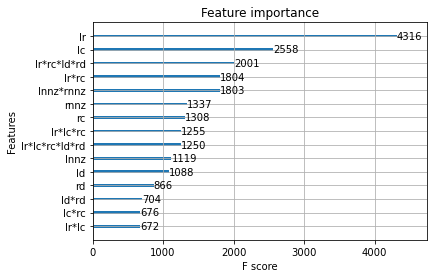

In [12]:
xgb.plot_importance(best_model)